In [1]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf #Framework para deep learning
from tensorflow import keras
from keras_tuner.tuners import RandomSearch #API que contiene la mayoría de funciones para las RN

In [70]:
x_train = []
y_train = []
path_data = 'data224/train'
names_files = os.listdir(path_data)
for i,file in enumerate(names_files):
    print(file)
    path_images = 'data224/train/'+file
    names_images = os.listdir(path_images)
    for name in names_images:
        path_image = os.path.join(path_images, name)
        image = Image.open(path_image)
        label = file.split('_')
        image=image.convert("L")
        x_train.append(np.array(image))
        y_train.append(i)

paper
rock
scissors


In [71]:
x_test = []
y_test = []
path_data = 'data224/test'
names_files = os.listdir(path_data)
for i,file in enumerate(names_files):
    print(file)
    path_images = 'data224/test/'+file
    names_images = os.listdir(path_images)
    for name in names_images:
        path_image = os.path.join(path_images, name)
        image = Image.open(path_image)
        label = file.split('_')
        image=image.convert("L")
        x_test.append(np.array(image))
        y_test.append(int(i))

paper
rock
scissors


In [72]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [73]:
x_train.shape

(2520, 300, 300)

In [74]:
### Estandarización de los datos
x_train2 = x_train/255
x_test2 = x_test/255
x_train2.shape

(2520, 300, 300)

In [75]:
model= keras.models.Sequential()

In [78]:
from tensorflow import keras
from tensorflow.keras import layers
##### REGULARIZACION #####
from tensorflow.keras import regularizers

model = keras.Sequential()

# Capa de entrada
model.add(layers.Input(shape=(300, 300, 1)))

# Bloque convolucional 1
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Bloque convolucional 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Bloque convolucional 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Bloque convolucional 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Aplanar y agregar capas densas
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(layers.Dense(3, activation='softmax'))  # 10 clases para los 10 tipos de animales

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 298, 298, 32)      320       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 35, 35, 128)     

In [8]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [79]:
history= model.fit(
    x_train2,
    y_train,
    epochs= 15,
    validation_split=0.2
)

Epoch 1/15
63/63 [==============================] - 100s 2s/step - loss: 3.6732 - accuracy: 0.6870 - val_loss: 9.8227 - val_accuracy: 0.0476
Epoch 2/15
63/63 [==============================] - 97s 2s/step - loss: 1.3807 - accuracy: 0.9732 - val_loss: 4.6281 - val_accuracy: 0.3552
Epoch 3/15
63/63 [==============================] - 102s 2s/step - loss: 0.8311 - accuracy: 0.9891 - val_loss: 6.3826 - val_accuracy: 0.2460
Epoch 4/15
63/63 [==============================] - 119s 2s/step - loss: 0.6191 - accuracy: 0.9727 - val_loss: 2.2960 - val_accuracy: 0.0258
Epoch 5/15
63/63 [==============================] - 139s 2s/step - loss: 0.7014 - accuracy: 0.9320 - val_loss: 4.0897 - val_accuracy: 0.2996
Epoch 6/15
63/63 [==============================] - 146s 2s/step - loss: 0.3953 - accuracy: 0.9980 - val_loss: 5.2547 - val_accuracy: 0.3413
Epoch 7/15
63/63 [==============================] - 141s 2s/step - loss: 0.3341 - accuracy: 0.9906 - val_loss: 4.6050 - val_accuracy: 0.2897
Epoch 8/15
63/

In [80]:
from sklearn.metrics import classification_report
class_names = ['papel','piedra','tijera']

y_hat = np.argmax(model.predict(x_test2), axis = 1)

print(classification_report(y_test, y_hat, target_names=class_names))

12/12 [==============================] - 5s 406ms/step
              precision    recall  f1-score   support

       papel       0.51      0.92      0.66       124
      piedra       0.80      0.71      0.75       124
      tijera       0.62      0.19      0.29       124

    accuracy                           0.61       372
   macro avg       0.64      0.61      0.57       372
weighted avg       0.64      0.61      0.57       372



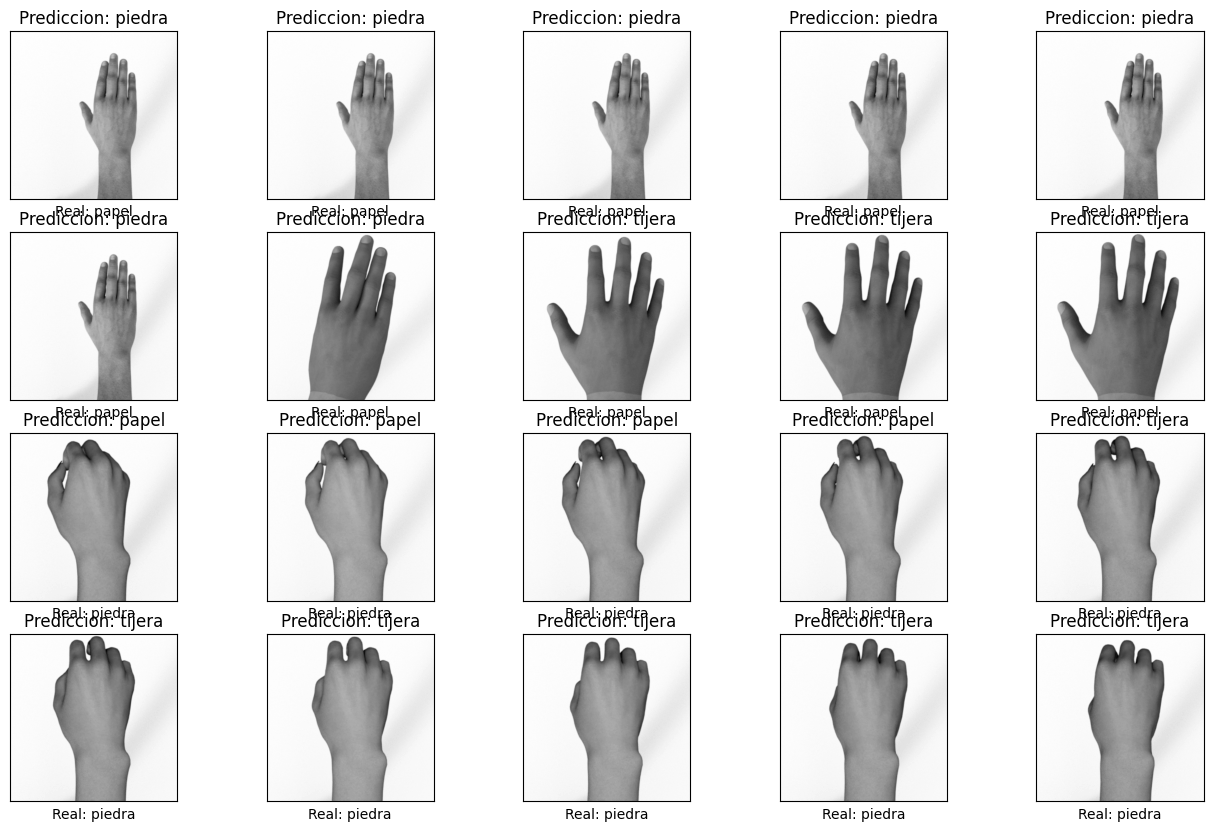

In [82]:
### Errores en la red neuronal
errors = np.nonzero(y_hat != y_test)[0]

# Visualizar las primeras 10 predicciones erroneas
plt.figure(figsize=(16, 10))
for i, incorrect in enumerate(errors[0:20]):
    plt.subplot(4,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[incorrect].reshape(300,300), cmap = 'gray')
    plt.title("Prediccion: {}".format(class_names[y_hat[incorrect]]))
    plt.xlabel("Real: {}".format(class_names[y_test[incorrect]]))

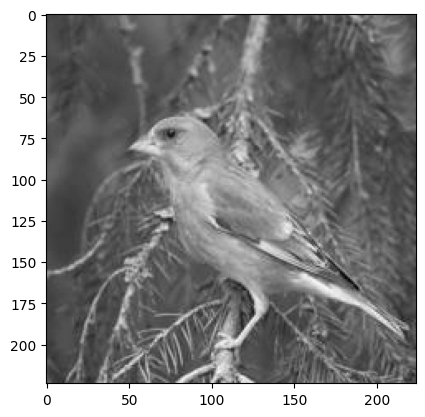

In [52]:
plt.imshow(x_train[1],cmap='gray')

In [49]:
x_train.shape

AttributeError: 'list' object has no attribute 'shape'